The aim of this notebook is to create a new scoring function that takes the masks and provides a score 0-1 on how favorable it is.

Favorability is....

## Setup

In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00


In [2]:
!pip install torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2 as cv

In [11]:
import numpy as np

In [5]:
image_train_folder = "/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/images/train"
image_val_folder = "/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/images/validation"
image_test_folder = "/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/images/test"

mask_train_folder = "/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/masks_clean/train"
mask_val_folder = "/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/masks_clean/validation"
mask_test_folder = "/content/drive/MyDrive/artificial-lunar-rocky-landscape-dataset/masks_clean/test"

In [117]:
mask_list = sorted(os.listdir(mask_train_folder))

In [118]:
image_list = sorted(os.listdir(image_train_folder))

In [25]:
img1 = cv.imread(os.path.join(mask_train_folder, mask_list[0]))
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

In [34]:
img1.shape

(480, 720, 3)

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
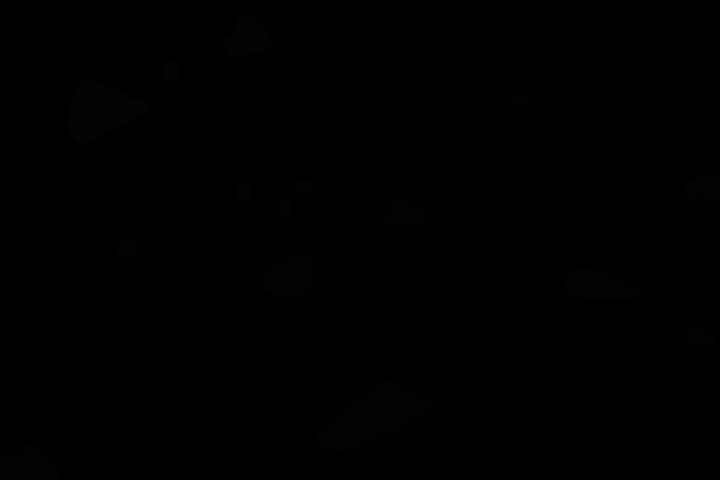

In [35]:
img1

In [30]:
# 4 classes example (background, rock, crater, shadow)
PALETTE = np.array([
    [0,   0,   0  ],  # class 0 - black - ground
    [255, 0,   0  ],  # class 1 - red - sky
    [0,   255, 0 ],   # class 2 - green - small rock
    [0, 0,   255  ],  # class 3 - red - big rock
], dtype=np.uint8)


In [86]:
color_mask = PALETTE[img1[..., 0]]

In [87]:
color_mask.shape

(480, 720, 3)

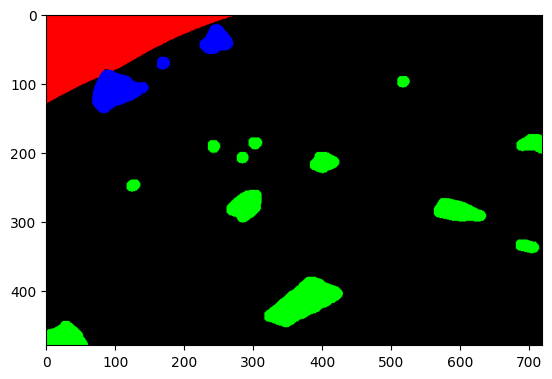

In [88]:
plt.imshow(color_mask)

## Important Stuff

In [130]:
def decode_n_visualize_masks(mask_path, image_path):
  # 4 classes example (background, rock, crater, shadow)
  PALETTE = np.array([
      [0,   0,   0  ],  # class 0 - black - ground
      [255, 0,   0  ],  # class 1 - red - sky
      [0,   255, 0 ],   # class 2 - green - small rock
      [0, 0,   255  ],  # class 3 - blue - big rock
  ], dtype=np.uint8)

  read = cv.imread(mask_path)
  RGB = cv.cvtColor(read, cv.COLOR_BGR2RGB) # 480 x 720 x 3
  toVisualize = PALETTE[RGB[..., 0]]

  # also read original image for comparision
  image = cv.imread(image_path)

  combined = np.hstack((image, toVisualize))
  plt.figure(figsize=(12, 6))
  plt.imshow(combined)
  plt.axis('off')


In [124]:
train_mask_full_paths = [os.path.join(mask_train_folder, mask_list[i]) for i in range(len(mask_list))]
train_image_full_paths = [os.path.join(image_train_folder, image_list[i]) for i in range(len(image_list))]

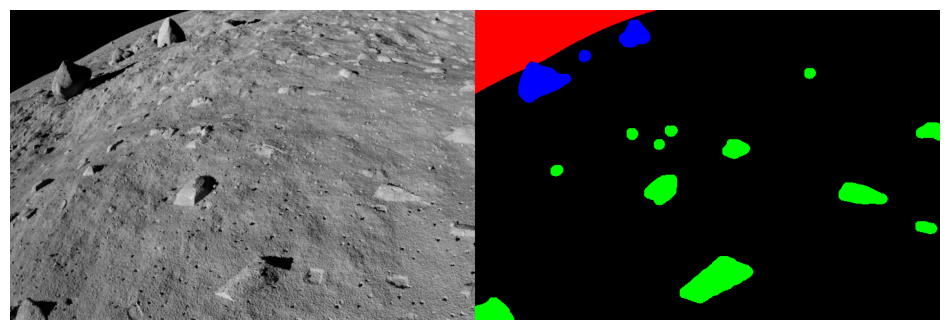

In [132]:
# testing function
decode_n_visualize_masks(train_mask_full_paths[0], train_image_full_paths[0])

Some rules for feasibility,
we can't be looking straight up or straight down, so I was thinking if the picture is < 80% sky, we're just gonna penalize the picture.

In [215]:
def scoring(mask_path):
  read = cv.imread(mask_path)
  RGB = cv.cvtColor(read, cv.COLOR_BGR2RGB) # 480 x 720 x 3
  RGB = RGB[..., 0] # condense 3rd dimension into one value

  h = RGB.shape[0]
  w = RGB.shape[1]
  total_pixels = h*w

  counts = np.bincount(RGB.flatten(), minlength=4) # count the classes so we get an array that is [# ground, #sky, #small rock, #big rock]
  # percents = counts / total_pixels # actually loking at the total percents doesn't matter right? we more care about percent s/lrock / ground pixels

  percents = counts.astype(float)
  # calculate ground and sky percents normally
  percents[0] = counts[0] / total_pixels # ground
  percents[1] = percents[1] / total_pixels # sky
  # calculate srock and lrock as percents of the ground pixels
  if counts[0] == 0:
    percents[2] = percents[2] / total_pixels # if there's no ground pixels then do normal percent
    percents[3] = percents[3] / total_pixels
  else:
    percents[2] = percents[2] / counts[0]
    percents[3] = percents[3] / counts[0]

  return percents

In [216]:
print(scoring(train_mask_full_paths[0]))

[0.89878472 0.04889178 0.0424699  0.01574593]


In [256]:
def feasibility(mask_path, srock_pen=50, lrock_pen=100, sigmoid_width=0.5):
  percents = scoring(mask_path)
  ground_p = percents[0]
  sky_p = percents[1]
  srock_p = percents[2] # small rock
  lrock_p = percents[3] # large rock

  # feasibility score
  f_score = 0

  if percents[1] == 0: # no sky so we're looking straight down
    f_score = 0 # doesn't give any information
  else:
    if srock_p == 0:
      srock_p = 0.00001 # to avoid dividing by 0
    if lrock_p == 0:
      lrock_p = 0.0001 # to avoid dividing by 0

    # as small rocks and large rocks percentage goes to 0 we want the f_score to go up
    f_score += 1/(srock_pen * srock_p) + 1/(lrock_pen * lrock_p)

  print(f_score)
  # use logistic function to get a confidence value
  confidence = 1 / (1 + np.exp(-sigmoid_width*f_score))
  return confidence

3
[8.82115162e-01 1.13217593e-01 4.84158250e-03 4.49388078e-04]
26.383362510632406
0.9999981339433955


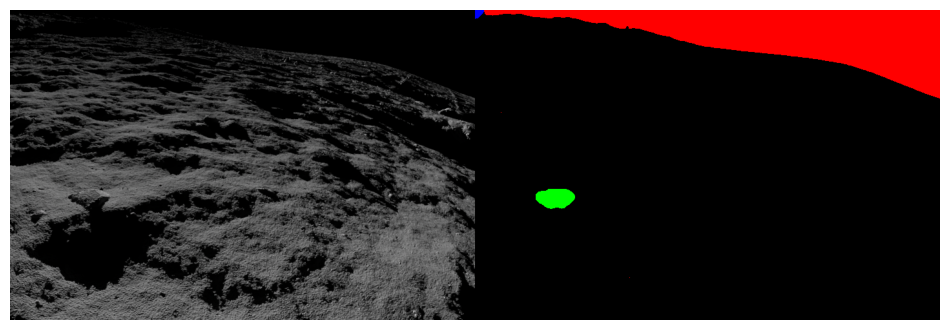

In [255]:
i = int(input())
decode_n_visualize_masks(train_mask_full_paths[i], train_image_full_paths[i])
print(scoring(train_mask_full_paths[i]))
print(feasibility(train_mask_full_paths[i]))

There are lot of tunable parameters for the scoring function.


*   srock_pen
*   lrock_pen
*   sigmoid_width
*   or even what value should replace 0.

